<a href="https://colab.research.google.com/github/ashishsingh0069/CODSOFT/blob/main/SPAM_SMS_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install -q scikit-learn pandas matplotlib seaborn nltk

import os
import zipfile
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sms-spam-collection-dataset' dataset.
Path to dataset files: /kaggle/input/sms-spam-collection-dataset


In [13]:
def find_dataset():
    p = Path(path)
    if p.is_file() and p.suffix == ".zip":
        print(f"Path is a zip file: {p}. Extracting...")
        zipfile.ZipFile(p).extractall(".")

        candidates = glob.glob("**/SMSSpamCollection*", recursive=True)
        if not candidates:
            candidates = glob.glob("**/spam.csv", recursive=True)
        print(f"Found candidates after zip extraction: {candidates}")
        return candidates[0] if candidates else None
    elif p.is_dir():
        print(f"Path is a directory: {p}. Searching for dataset file...")

        candidates = glob.glob(str(p / "SMSSpamCollection*"))
        if candidates:
            print(f"Found SMSSpamCollection* directly: {candidates}")
            return candidates[0]

        candidates = glob.glob(str(p / "spam.csv"))
        if candidates:
            print(f"Found spam.csv directly: {candidates}")
            return candidates[0]

        candidates = glob.glob(str(p / "**" / "SMSSpamCollection*"), recursive=True)
        if candidates:
            print(f"Found SMSSpamCollection* recursively: {candidates}")
            return candidates[0]

        candidates = glob.glob(str(p / "**" / "spam.csv"), recursive=True)
        if candidates:
            print(f"Found spam.csv recursively: {candidates}")
            return candidates[0]
    print("No dataset file found.")
    return None

dataset_file = find_dataset()
print("Using:", dataset_file)

df = pd.read_csv(dataset_file, sep=",", encoding='latin-1')
df.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)
df.head()

Path is a directory: /kaggle/input/sms-spam-collection-dataset. Searching for dataset file...
Found spam.csv directly: ['/kaggle/input/sms-spam-collection-dataset/spam.csv']
Using: /kaggle/input/sms-spam-collection-dataset/spam.csv


,label,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


(5572, 5)
label
ham     4825
spam     747
Name: count, dtype: int64


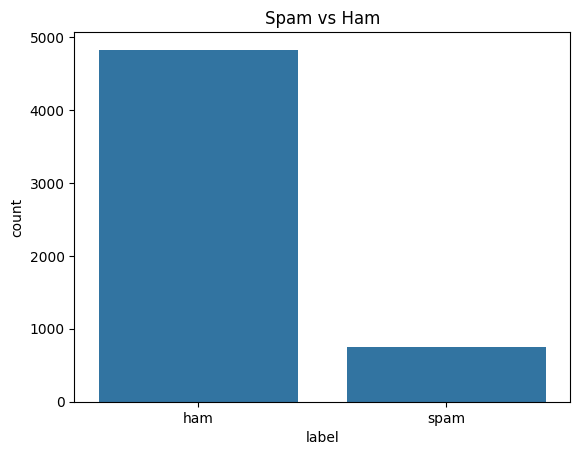

In [14]:
print(df.shape)
print(df.label.value_counts())

sns.countplot(data=df, x="label")
plt.title("Spam vs Ham")
plt.show()


In [19]:
import re

stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)

    tokens = nltk.word_tokenize(text)
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and len(t) > 1]
    return " ".join(tokens)

df["message_clean"] = df["message"].astype(str).apply(clean_text)
df.head()

,label,message,Unnamed: 2,Unnamed: 3,Unnamed: 4,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,go jurong point crazi avail bugi great world l...
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,free entri wkli comp win fa cup final tkt st m...
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,nah think goe usf live around though


In [21]:
X = df["message_clean"]
y = df["label"].map({"ham": 0, "spam": 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(len(X_train), len(X_test))


4457 1115


In [23]:
tfidf = TfidfVectorizer(max_df=0.9, min_df=2, ngram_range=(1,2))

pipelines = {
    "NaiveBayes": Pipeline([("tfidf", tfidf), ("clf", MultinomialNB())]),
    "LogisticRegression": Pipeline([("tfidf", tfidf), ("clf", LogisticRegression(max_iter=2000))]),
    "LinearSVC": Pipeline([("tfidf", tfidf), ("clf", LinearSVC(max_iter=5000))])
}


In [24]:
results = {}

for name, model in pipelines.items():
    print("\nTraining:", name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = [acc, prec, rec, f1]

    print(f"{name} → Acc:{acc:.4f}, Prec:{prec:.4f}, Rec:{rec:.4f}, F1:{f1:.4f}")
    print(confusion_matrix(y_test, y_pred))



Training: NaiveBayes
NaiveBayes → Acc:0.9686, Prec:0.9914, Rec:0.7718, F1:0.8679
[[965   1]
 [ 34 115]]

Training: LogisticRegression
LogisticRegression → Acc:0.9686, Prec:0.9914, Rec:0.7718, F1:0.8679
[[965   1]
 [ 34 115]]

Training: LinearSVC
LinearSVC → Acc:0.9857, Prec:0.9784, Rec:0.9128, F1:0.9444
[[963   3]
 [ 13 136]]


In [25]:
res_df = pd.DataFrame(results, index=["Accuracy","Precision","Recall","F1"]).T
res_df.sort_values("F1", ascending=False)


,Accuracy,Precision,Recall,F1
LinearSVC,0.98565,0.978417,0.912752,0.944444
NaiveBayes,0.96861,0.991379,0.771812,0.867925
LogisticRegression,0.96861,0.991379,0.771812,0.867925


Best Model: LinearSVC
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.98      0.91      0.94       149

    accuracy                           0.99      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115



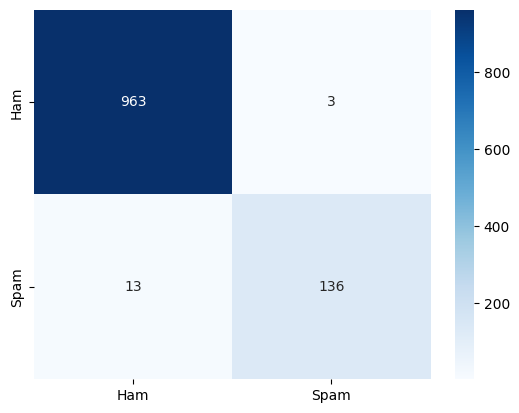

In [26]:
best_model_name = res_df.sort_values("F1", ascending=False).index[0]
best_model = pipelines[best_model_name]

print("Best Model:", best_model_name)
print(classification_report(y_test, best_model.predict(X_test)))

cm = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Ham","Spam"], yticklabels=["Ham","Spam"])
plt.show()


In [27]:
import joblib

joblib.dump(best_model, "sms_spam_detector.pkl")
print("Model saved as sms_spam_detector.pkl")


Model saved as sms_spam_detector.pkl


In [28]:
def predict_sms(texts):
    clean = [clean_text(t) for t in texts]
    preds = best_model.predict(clean)
    return pd.DataFrame({"SMS": texts, "Label": preds})

samples = [
    "Free entry to win a brand new iPhone!",
    "Are you coming to office tomorrow?",
    "URGENT: Your ATM card is blocked. Send OTP."
]

predict_sms(samples)


,SMS,Label
0,Free entry to win a brand new iPhone!,1
1,Are you coming to office tomorrow?,0
2,URGENT: Your ATM card is blocked. Send OTP.,0
